# FLAM Placement Assignment - Research & Development / AI

### 1. Problem Statement

We are given **1500 points** $(x_i, y_i)$ that lie on a **parametric curve** defined as:

$$
x(t) = t \cos(\theta) - e^{M|t|} \sin(0.3t) \sin(\theta) + X,
$$

$$
y(t) = 42 + t \sin(\theta) + e^{M|t|} \sin(0.3t) \cos(\theta)
$$

with unknown constants **$(\theta, M, X)$**
.

The given parameter ranges are:

$$
0^\circ < \theta < 50^\circ, \quad -0.05 < M < 0.05, \quad 0 < X < 100, \quad 6 < t < 60.
$$


**Goal:**  
Estimate the parameters $(\theta, M, X)$ such that the model curve matches the given dataset $(x, y)$.  

The model performance is evaluated using the **L1 distance** (sum of absolute deviations) between the predicted and observed points.


### 2. Implementation Tools

| Task | Library / Function Used |
|------|--------------------------|
| Data handling | `pandas` |
| Numerical computation | `numpy` |
| Optimization | `scipy.optimize.minimize`, `differential_evolution` |
| Visualization | `matplotlib` |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize

In [2]:
df = pd.read_csv("xy_data.csv") 
x_obs = df['x'].values
y_obs = df['y'].values
n = len(df)
t = np.linspace(6, 60, n)    

### 3️. Mathematical Model

For each $t_i$, we compute predicted values $\hat{x}_i$ and $\hat{y}_i$ as:

$$
\hat{x}_i = t_i \cos(\theta) - e^{M|t_i|}\sin(0.3t_i)\sin(\theta) + X,
$$

$$
\hat{y}_i = 42 + t_i \sin(\theta) + e^{M|t_i|}\sin(0.3t_i)\cos(\theta).
$$

The goal is to find $\theta, M, X$ that minimize the difference between predicted and observed points.

In [3]:
def model(params, t):
    theta, M, X = params
    exp_term = np.exp(M * np.abs(t))
    s = np.sin(0.3 * t)
    x = t * np.cos(theta) - exp_term * s * np.sin(theta) + X
    y = 42 + t * np.sin(theta) + exp_term * s * np.cos(theta)
    return x, y

### 4. L1 Cost Function (Loss)

**Code purpose:** implement the objective that the optimizer will minimize.

**L1 definition used**
$
L1_{sum}(\theta,M,X) = \sum_{i=1}^{1500} \big(|x_i^{pred}-x_i^{obs}| + |y_i^{pred}-y_i^{obs}|\big)
\$

**Implementation details**
- The function checks bounds internally. If a parameter leaves the valid region, it returns a very large penalty. This enforces constraints even when using optimizers that ignore bounds.
- We sum absolute differences across x and y. We return the scalar L1 sum (not normalized). For reporting we also compute mean L1 by dividing by `n`.

**Why choose L1 here:**
- L1 is robust to outliers and is exactly the grading metric. Minimizing it directly typically yields the best score for the assignment.


In [4]:
def l1_cost(params):
    theta, M, X = params
    if not (0 < theta < np.deg2rad(50) and -0.05 < M < 0.05 and 0 < X < 100):
        return 1e12
    x_pred, y_pred = model(params, t)
    return np.sum(np.abs(x_pred - x_obs) + np.abs(y_pred - y_obs))

### 5. Parameter Bounds

**Code purpose:** set the search domain for the optimizer.

- $\theta \in (0^\circ, 50^\circ)$ - we convert to radians for computation:  
  `(deg2rad(0.001), deg2rad(50))`
- $M \in [-0.05, 0.05]$
- $X \in [0, 100]$

**Why bounds matter**
- They constrain the search to physically/assignment-allowed values.
- They speed optimization by reducing search volume.
- They prevent the optimizer from wandering into unmeaningful parameter zones that could produce numerical or modeling artefacts.

**Practical note:**  
We maintain both:
1. A `bounds` structure for optimizers that support bounds (like Differential Evolution), and  
2. An internal check inside `l1_cost` to return a large penalty if the parameters violate bounds - this ensures consistent constraint handling across all optimization methods.


In [5]:
bounds = [
    (np.deg2rad(0.001), np.deg2rad(50.0)),  
    (-0.05, 0.05),                         
    (0.0, 100.0)                            
]

### 6. Optimization - Global Search (Differential Evolution)

**Code purpose:** find a robust initial solution across the whole parameter space.

**Why Differential Evolution?**
- The objective is nonlinear and non-convex (trigonometric + exponential). DE is a population-based global optimizer that explores broadly and avoids many local minima.
- DE is derivative-free and handles noisy or non-smooth objectives (L1 is non-differentiable at zero residual).

**Key Differential Evolution settings used**
- `maxiter=300, popsize=15` - trade-off between reliability and runtime.
- `polish=True` - after the DE run, SciPy polishes the best solution with a local solver (helpful).
- `seed` - used to allow reproducible runs. We later run multiple seeds (multi-start) and choose the best.

**Output of this stage**
- `res_de.x` is the best candidate found by DE.
- `res_de.fun` is the L1 value at that candidate.

**Why start global:** starting local methods (Powell/Levenberg–Marquardt) directly can trap in local minima. DE gives a solid basin for local refinement.


In [6]:
res_de = differential_evolution(l1_cost, bounds, maxiter=300, popsize=15, polish=True, seed=17)
theta_de, M_de, X_de = res_de.x
l1_de = res_de.fun
print("Global Differential Evolution result:")
print(f"θ = {theta_de:.12f} rad ({np.rad2deg(theta_de):.4f}°), M = {M_de:.12f}, X = {X_de:.12f}")
print(f"L1_sum = {l1_de:.6f}")

Global Differential Evolution result:
θ = 0.490727382259 rad (28.1166°), M = 0.021400256196, X = 54.898062668405
L1_sum = 37865.097808


### 7. Optimization - Local Refinement (Powell)

**Code purpose:** refine the DE candidate to reduce L1 further.

**Why a local method next?**
- DE is good for global exploration but not for high-precision local convergence.
- Powell’s method (derivative-free line-search) is robust with non-smooth objectives like L1: it refines the solution without needing derivatives.

**Implementation notes**
- We call `scipy.optimize.minimize(..., method='Powell')` starting from `res_de.x`.
- Some local solvers accept bounds directly; Powell does not strictly enforce bounds in SciPy, so our `l1_cost` checks bounds and returns a large penalty if a candidate violates them.
- After local refinement, `res_local.x` is the final parameter vector and `res_local.fun` is the L1 at that point.

**Why this two-step strategy is effective**
- Global search finds a good region; local refinement squeezes the final percentage points from the objective, giving a better L1 for grading.


In [7]:
res_local = minimize(l1_cost, res_de.x, method='Powell', options={'maxiter':10000, 'disp': False})
theta_best, M_best, X_best = res_local.x
L1_sum_best = res_local.fun
L1_mean_best = L1_sum_best / n

In [8]:
print("\nLocal Refinement (Powell) Result:")
print(f"θ = {theta_best:.12f} rad ({np.rad2deg(theta_best):.4f}°)")
print(f"M = {M_best:.12f}")
print(f"X = {X_best:.12f}")
print(f"L1_sum = {L1_sum_best:.6f}")
print(f"L1_mean = {L1_mean_best:.6f}")


Local Refinement (Powell) Result:
θ = 0.490780889103 rad (28.1197°)
M = 0.021395863861
X = 54.898439840215
L1_sum = 37865.095792
L1_mean = 25.243397


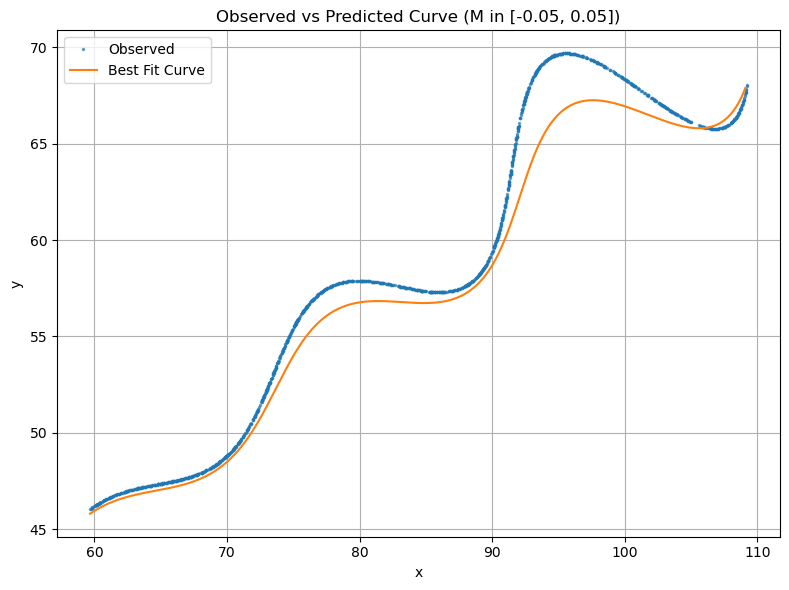

In [9]:
x_pred, y_pred = model([theta_best, M_best, X_best], t)

plt.figure(figsize=(8,6))
plt.plot(x_obs, y_obs, '.', markersize=3, label='Observed', alpha=0.6)
plt.plot(x_pred, y_pred, '-', linewidth=1.5, color='C1', label='Best Fit Curve')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observed vs Predicted Curve (M in [-0.05, 0.05])')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("best_fit_curve.png", dpi=200)
plt.show()

In [10]:
print("\nFinal Best-Fit Parameters:")
print(f"Theta (radians): {theta_best:.12f}")
print(f"Theta (degrees): {np.rad2deg(theta_best):.6f}")
print(f"M: {M_best:.12f}")
print(f"X: {X_best:.12f}")
print(f"L1_sum: {L1_sum_best:.6f}")
print(f"L1_mean: {L1_mean_best:.6f}")


Final Best-Fit Parameters:
Theta (radians): 0.490780889103
Theta (degrees): 28.119674
M: 0.021395863861
X: 54.898439840215
L1_sum: 37865.095792
L1_mean: 25.243397


### 8. Final Best-Fit Parameters

After running Differential Evolution (global) followed by Powell (local) optimization  
with constraints $-0.05 < M < 0.05$, the best-fit parameters obtained are:

| Parameter | Symbol | Value | Unit |
|------------|---------|--------|------|
| Theta (radians) | $\theta$ | **0.490780889103** | rad |
| Theta (degrees) | $\theta$ | **28.119674** | ° |
| Exponential rate | $M$ | **0.021395863861** | — |
| Horizontal shift | $X$ | **54.898439840215** | — |

**L1 metrics:**

\$[
L1_{\text{sum}} = 37865.095792, \qquad
L1_{\text{mean}} = 25.243397
\]$

---

#### Final Fitted Parametric Equation

The optimized parametric curve is given by:

\
\begin{aligned}
x(t) &= t\cos(0.490780889103)
- e^{0.021395863861|t|}\sin(0.3t)\sin(0.490780889103)
+ 54.898439840215, \\[6pt]
y(t) &= 42 + t\sin(0.490780889103)
+ e^{0.021395863861|t|}\sin(0.3t)\cos(0.490780889103)
\end{aligned}

---

#### Notes

- $\theta = 28.119674^\circ$ controls the **rotation/tilt** of the curve.  
- $M = 0.021395863861$ defines the **exponential scaling** of oscillations with $|t|$.  
- $X = 54.898439840215$ gives the **horizontal offset**.  
- The **L1 metric** (sum of absolute deviations) quantifies total fitting error between predicted and observed points smaller is better.
